# Calculating elementary compositions (eCs) for a genome-scale community #

In [1]:
import multiprocessing

multiprocessing.set_start_method('spawn')

import cobra
import pycomo
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import warnings
import os

sb.set_theme()

2025-11-17 11:45:04,757 - pycomo - INFO - Logger initialized.
2025-11-17 11:45:04,760 - pycomo - INFO - Process Pool Logger initialized.
2025-11-17 11:45:04,761 - pycomo - INFO - Utils Logger initialized.
2025-11-17 11:45:04,763 - pycomo - INFO - Multiprocess Logger initialized.


In [2]:
cobra.Configuration().processes = 1

In [3]:
pycomo.configure_logger(level="warning")

## Loading the model ##

In [4]:
model_path = "data/community_models/M. smithii_B. thetaiotaomicron_ms_open_min_med_tp_10.xml"
model = pycomo.CommunityModel.load(model_path)

## Calculating eCs ##

In [5]:
member_names = model.get_member_names()
model.convert_to_fixed_growth_rate()
ecs = {}
try:
    for i in [j*0.001 for j in range(1001)]:
        if (i * 100) % 10 == 0:
            print(f"Calculating for growth rate {i}")
        comp_df = model.feasible_composition_range(i)
        gamma_min = list(comp_df[comp_df["reaction_id"] == member_names[0]+"_fraction_reaction"]["min_flux"])[0]
        gamma_max = list(comp_df[comp_df["reaction_id"] == member_names[0]+"_fraction_reaction"]["max_flux"])[0]
        ecs[i] = [gamma_min, gamma_max]
except cobra.exceptions.Infeasible:
    print(f"Growth rate of {i} is infeasible - stopping.")

Calculating for growth rate 0.0
Calculating for growth rate 0.1
Calculating for growth rate 0.2
Calculating for growth rate 0.3
Calculating for growth rate 0.4
Calculating for growth rate 0.5
Calculating for growth rate 0.6
Calculating for growth rate 0.7000000000000001
Calculating for growth rate 0.8
Growth rate of 0.852 is infeasible - stopping.


Let's have a look at the highest growth rate:

In [6]:
max_gr = max(ecs.keys())
gamma_min, gamma_max = ecs[max_gr]
print(f"Maximum growth rate captured is {max_gr}")
print(f"eC 1: gamma (M. smithii) = {gamma_min}")
print(f"eC 2: gamma (M. smithii) = {gamma_max}")

Maximum growth rate captured is 0.851
eC 1: gamma (M. smithii) = 0.4252821963377411
eC 2: gamma (M. smithii) = 0.5062424819722087


## Plot the eCs against the growth rate ##

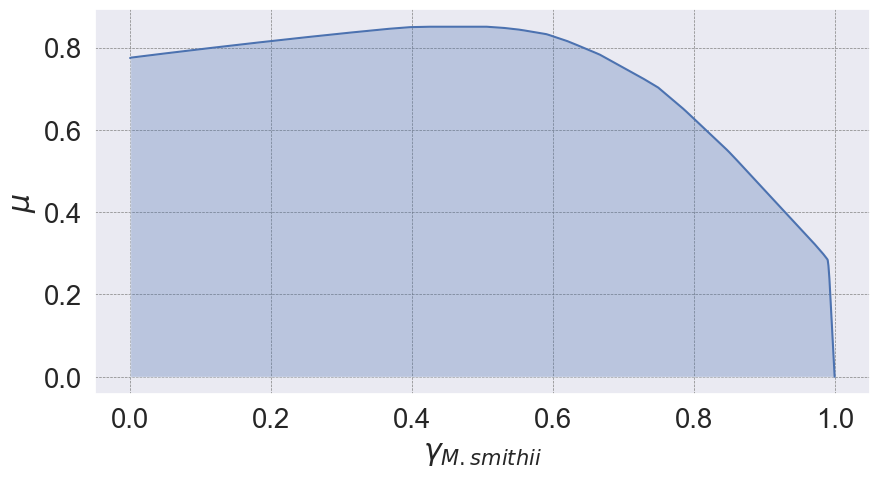

In [8]:
mu_join = {}
for k, v in ecs.items():
    mu_join[v[0]] = k
for k in list(ecs.keys())[::-1]:
    mu_join[ecs[k][1]] = k

member_names = model.get_member_names()
name_conv = {"A": "M. smithii", "N": "B. thetaiotaomicron"}

member_abbrev = [name_conv[n[0]] for n in member_names]
    
sb.set(font_scale=1.8)
plt.plot(mu_join.keys(), mu_join.values())
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.fill_between(mu_join.keys(), mu_join.values(), alpha=0.3)
plt.xlabel("$\gamma_{" + member_abbrev[0] + "}$")
plt.ylabel("$\mu$")
#plt.title("Maximum Growth-Rate of B. tim - M. smithii Co-Culture (Minimal Medium)")
plt.gcf().set_size_inches(10,5)
plt.savefig("figures/growth_rate_btim_msmithii_min_med_fixed_mu.pdf", bbox_inches="tight")